# Libraries

In [1]:
from datetime import date, datetime
import numpy as np
import pandas as pd
pd.options.display.max_columns = None
import matplotlib.pyplot as plt
import random
import re
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler

# Load data

The historical data of surveys is in the site https://survey.stackoverflow.co/

In [2]:
schema = pd.read_csv('./survey_results_schema.csv')
survey = pd.read_csv('./survey_results_public.csv')

# EDA and Data transformation

## Preliminary

In [3]:
schema['type'].value_counts()

MC        48
Matrix    16
DB         9
TE         3
Meta       1
Slider     1
Name: type, dtype: int64

In [4]:
schema[schema['type'] == 'TE']

,qid,qname,question,force_resp,type,selector
24,QID51,CompTotal,What is your current total <b>annual</b> compe...,False,TE,SL
45,QID325,SOAI,Artificial Intelligence (AI) tools have gained...,False,TE,SL
52,QID321,AIOpen,Please describe how you would expect your work...,False,TE,SL


In [5]:
survey['Q120'].value_counts()

I agree    89184
Name: Q120, dtype: int64

Two first columns have not importance: ResponseId, Q120

In [6]:
columns_to_drop = ['ResponseId', 'Q120', 'SOAI']

survey.drop(columns=columns_to_drop, inplace=True)
print(survey.shape)

(89184, 81)


In [7]:
survey.dropna(subset=['ConvertedCompYearly'], axis=0, inplace=True)
print(survey.shape)

(48019, 81)


In [8]:
survey = survey[survey['ConvertedCompYearly'] < np.quantile(survey['ConvertedCompYearly'], 0.95)]

We want to do an analysis with Java and Python languages, so we need indentify it, so let's define the next function which detects 'Java' or 'Python' substrings.

In [9]:
def java_python(string): 
    '''
    INPUT
    string (str): the string to identify 'Java' or 'Python substrings'
    
    OUTPUT
    return: 'Java' or 'Python' if they are substrings of string input, False if not
    '''
    if string in ['Java', 'Python']: return string
    elif re.search('Python', string):
        if re.search('Java[;].*', string):
            return False
        else: return 'Python'
    elif re.search('Java[;].*', string):
        if re.search('Python', string):
            return False
        else: return 'Java'
    else: return False
java_python('Java')

'Java'

Python is the most popular language between the respondents!

In [10]:
survey['Python or Java'] = survey['LanguageHaveWorkedWith'].apply(lambda x: java_python(str(x)))
survey = survey[survey['Python or Java'].isin(['Java', 'Python'])]
print(survey.shape)
print(survey['Python or Java'].value_counts())

(20353, 82)
Python    14256
Java       6097
Name: Python or Java, dtype: int64


In [11]:
java = survey[survey['Python or Java'] == 'Java'].copy()
python = survey[survey['Python or Java'] == 'Python'].copy()

As we have now these two dataframes, we can ask the questions like which another language work the programmers with? or, there are some differences in roles between thes two languages?, for example Python is widely used for data science projects so maybe is most frequent because the data scientist majority respondents.

In [12]:
def variable_barplot(column, language):
    '''
    INPUT
    column (pandas Series): the column to plot
    language (str): the language to exclude between the categories of column
    
    OUTPUT
    return: barplot of the proportion of the categories of the column
    '''
    categories = set()
    column = column.astype(str)
    unique_values = np.unique(column.str.split(';'))
    for categories_list in unique_values:
        categories = categories | set(categories_list)
    categories = list(categories - {language})

    frequency = []
    for language in categories:
        c = 0
        for lista in column.str.split(';'):
            if language in lista: c += 1
                frequency.append(c)

    def addlabels(x, y):
        for i in range(len(x)):
            plt.text(i, y[i], f'{round(y[i]*100, 1)}%', ha='center', fontsize='x-small')

    df = pd.DataFrame({'language': categories, 'frequency': frequency}).sort_values(by='frequency', ascending=False).reset_index(drop=True)
    df['%'] = df['frequency']/df['frequency'].sum()
    df[:20].plot(kind='bar', x='language', y='%', width=1, legend=None, ylabel='frequency', rot=90)
    addlabels(x=df['language'][:20], y=df['%'][:20])

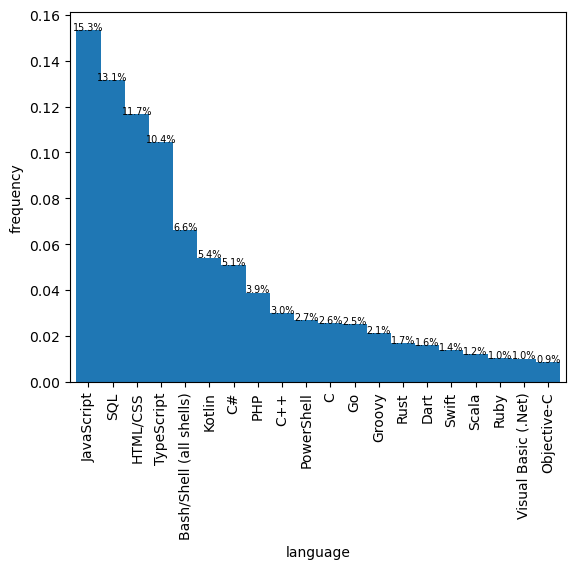

In [13]:
variable_barplot(java['LanguageHaveWorkedWith'], 'Java')

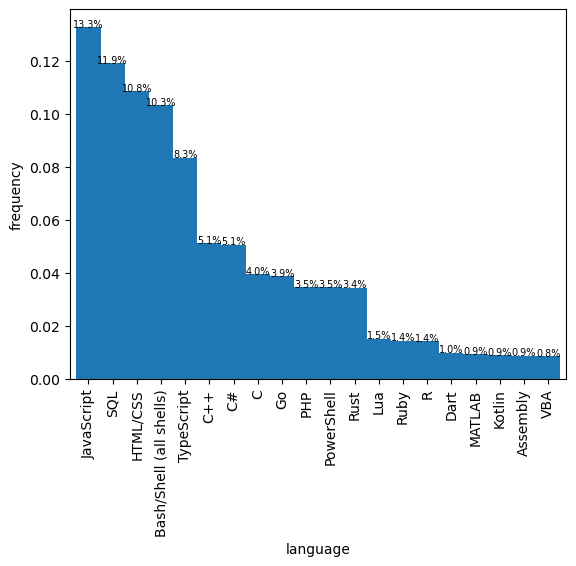

In [14]:
variable_barplot(python['LanguageHaveWorkedWith'], 'Python')

There aren't big differences between the toolkit of other languages used by respondents! Let's see whether there are notable differences between the roles.

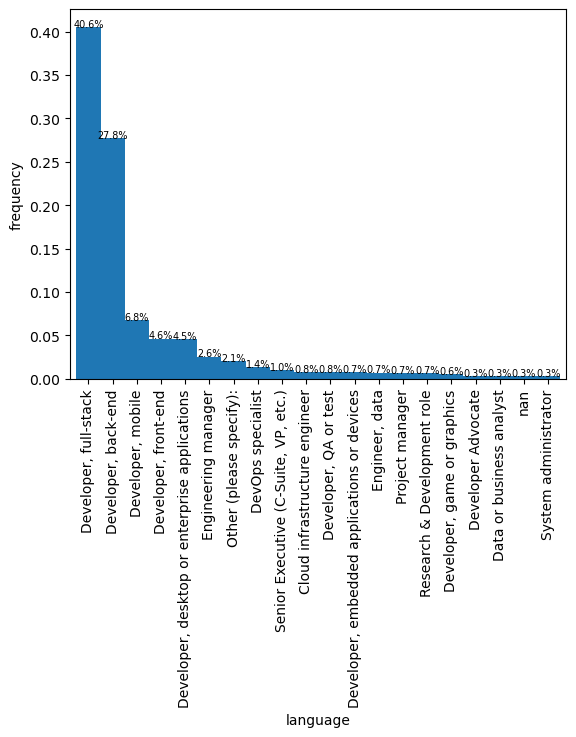

In [15]:
variable_barplot(java['DevType'], '')

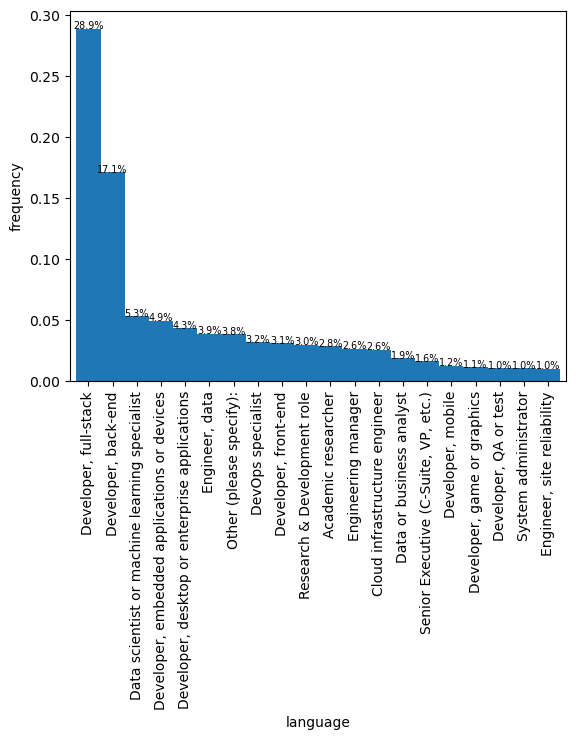

In [16]:
variable_barplot(python['DevType'], '')

There are some notable differences between roles! For example the third type of Python developers is Data science specialist, and in general the scientific or academic use of Python is more frequent than Java, Research & Development role: Python 3% vs Java 0.7%, Academic researcher: Python 2.8% vs Java 0%.

Will the salary change according to these differences in roles?

## Java

In [18]:
java.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6097 entries, 6 to 89171
Data columns (total 82 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   MainBranch                           6097 non-null   object 
 1   Age                                  6097 non-null   object 
 2   Employment                           6094 non-null   object 
 3   RemoteWork                           6082 non-null   object 
 4   CodingActivities                     6080 non-null   object 
 5   EdLevel                              6097 non-null   object 
 6   LearnCode                            6089 non-null   object 
 7   LearnCodeOnline                      4765 non-null   object 
 8   LearnCodeCoursesCert                 2872 non-null   object 
 9   YearsCode                            6083 non-null   object 
 10  YearsCodePro                         6070 non-null   object 
 11  DevType                      

In [19]:
java.sample(2)

,MainBranch,Age,Employment,RemoteWork,CodingActivities,EdLevel,LearnCode,LearnCodeOnline,LearnCodeCoursesCert,YearsCode,YearsCodePro,DevType,OrgSize,PurchaseInfluence,TechList,BuyNewTool,Country,Currency,CompTotal,LanguageHaveWorkedWith,LanguageWantToWorkWith,DatabaseHaveWorkedWith,DatabaseWantToWorkWith,PlatformHaveWorkedWith,PlatformWantToWorkWith,WebframeHaveWorkedWith,WebframeWantToWorkWith,MiscTechHaveWorkedWith,MiscTechWantToWorkWith,ToolsTechHaveWorkedWith,ToolsTechWantToWorkWith,NEWCollabToolsHaveWorkedWith,NEWCollabToolsWantToWorkWith,OpSysPersonal use,OpSysProfessional use,OfficeStackAsyncHaveWorkedWith,OfficeStackAsyncWantToWorkWith,OfficeStackSyncHaveWorkedWith,OfficeStackSyncWantToWorkWith,AISearchHaveWorkedWith,AISearchWantToWorkWith,AIDevHaveWorkedWith,AIDevWantToWorkWith,NEWSOSites,SOVisitFreq,SOAccount,SOPartFreq,SOComm,AISelect,AISent,AIAcc,AIBen,AIToolInterested in Using,AIToolCurrently Using,AIToolNot interested in Using,AINextVery different,AINextNeither different nor similar,AINextSomewhat similar,AINextVery similar,AINextSomewhat different,TBranch,ICorPM,WorkExp,Knowledge_1,Knowledge_2,Knowledge_3,Knowledge_4,Knowledge_5,Knowledge_6,Knowledge_7,Knowledge_8,Frequency_1,Frequency_2,Frequency_3,TimeSearching,TimeAnswering,ProfessionalTech,Industry,SurveyLength,SurveyEase,ConvertedCompYearly,Python or Java
29639,I am a developer by profession,35-44 years old,"Independent contractor, freelancer, or self-em...",Remote,Contribute to open-source projects;Professiona...,Some college/university study without earning ...,Books / Physical media;Online Courses or Certi...,Formal documentation provided by the owner of ...,NaN,25,23,"Developer, full-stack","Just me - I am a freelancer, sole proprietor, ...",I have some influence,Investigate,Ask developers I know/work with;Visit develope...,Turkey,TRY\tTurkish lira,95000.0,C;C#;C++;Delphi;F#;HTML/CSS;Java;JavaScript;PH...,NaN,Firebase Realtime Database;IBM DB2;MariaDB;Mic...,NaN,Amazon Web Services (AWS);Cloudflare;Firebase;...,NaN,ASP.NET;ASP.NET CORE;Django;jQuery;Laravel;Nex...,NaN,.NET Framework (1.0 - 4.8);JAX;Xamarin,.NET (5+),Composer;Docker;Gradle;Make;MSBuild;MSVC;npm;V...,NaN,Android Studio;Atom;Eclipse;IntelliJ IDEA;Netb...,NaN,MacOS;Other Linux-based;Windows,NaN,Jira,NaN,IRC;Microsoft Teams;Skype;Slack;Whatsapp;Zoom,NaN,Bing AI;ChatGPT;Google Bard AI;WolframAlpha,NaN,NaN,NaN,Stack Overflow;Stack Exchange,A few times per week,Yes,I have never participated in Q&A on Stack Over...,"No, not really",Yes,Indifferent,Increase productivity;Speed up learning;Improv...,Neither trust nor distrust,Debugging and getting help;Testing code;Commit...,Learning about a codebase;Writing code;Documen...,Project planning;Collaborating with teammates,NaN,Learning about a codebase,Documenting code,NaN,Writing code,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Appropriate in length,Easy,4466.0,Java
44561,I am a developer by profession,35-44 years old,"Employed, full-time",Remote,I don’t code outside of work,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Books / Physical media;Online Courses or Certi...,Formal documentation provided by the owner of ...,NaN,26,16,"Developer, back-end",100 to 499 employees,I have little or no influence,NaN,Start a free trial;Ask developers I know/work ...,Spain,EUR European Euro,62000.0,Java;JavaScript;SQL;TypeScript,Java,Clickhouse;Dynamodb;MongoDB;Oracle;PostgreSQL;...,NaN,Amazon Web Services (AWS),Amazon Web Services (AWS),Angular;AngularJS;Node.js;Spring Boot,Spring Boot,Spring Framework,Apache Kafka;Micronaut;Quarkus;Spring Framework,Chocolatey;Docker;Maven (build tool);npm;Pip,Docker;Maven (build tool),DataGrip;IntelliJ IDEA;Notepad++;Sublime Text,DataGrip;IntelliJ IDEA,Windows,MacOS,Confluence;Jira;Miro;Notion,Notion,Google Meet;Matrix;Microsoft Teams;Skype;Slack...,Discord;Google Meet;Slack,ChatGPT;WolframAlpha,Bing AI,NaN,NaN,Stack Overflow;Stack Exchange,Multiple times per day,Yes,A few times per month or weekly,Neu

In [20]:
java['ConvertedCompYearly'].describe()

count      6097.000000
mean      75303.028867
std       50355.140960
min           1.000000
25%       38552.000000
50%       66036.000000
75%      103824.000000
max      228414.000000
Name: ConvertedCompYearly, dtype: float64

<AxesSubplot:>

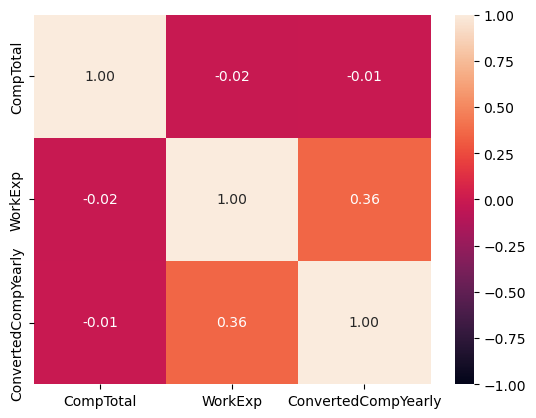

In [21]:
sns.heatmap(java.select_dtypes('float64', 'int').corr(), vmin=-1, vmax=1, annot=True, fmt='.2f') # numerical variables are not explicative of objective variable

In [22]:
survey_schema = pd.DataFrame({'question': survey.columns}).merge(schema[['qname', 'question']], left_on='question', right_on='qname', how='left')

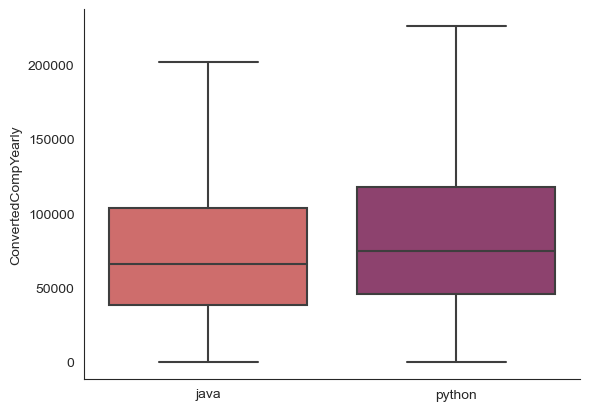

In [23]:
combined_dfs = pd.DataFrame({'java': java['ConvertedCompYearly'], 'python': python['ConvertedCompYearly']})
sns.set_style('white')
sns.boxplot(data=combined_dfs, palette='flare', showfliers=False)
sns.despine()
plt.ylabel('ConvertedCompYearly')
plt.show()

AISearchWantToWorkWith


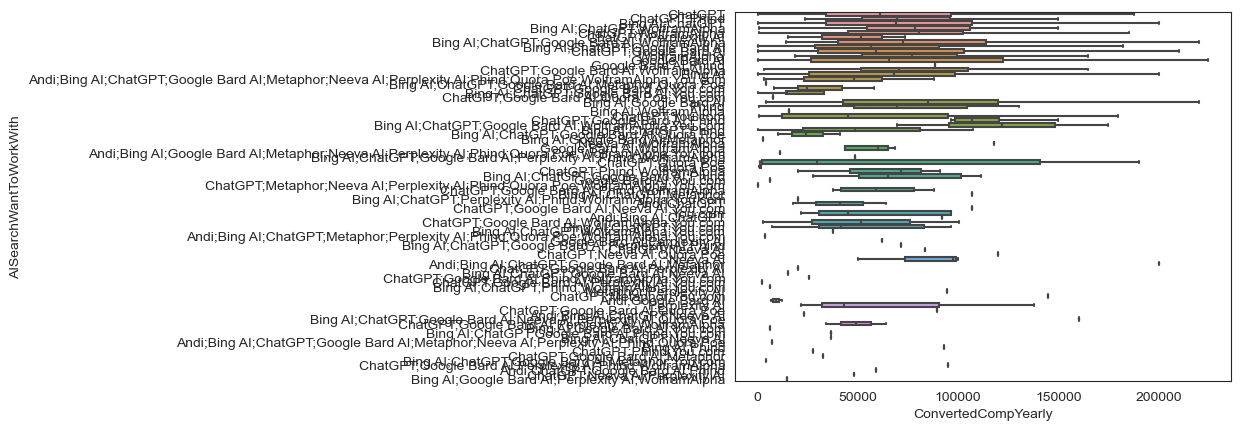

In [24]:
column = java.columns[40]
print(column)
sns.boxplot(data=java, x='ConvertedCompYearly', y=column, showfliers=False);

In [25]:
objective_variable = ['ConvertedCompYearly']
categorical_variables = java.select_dtypes(include=['object']).columns

excluir = ['Python or Java', 'Currency']
categorical_variables = categorical_variables[~categorical_variables.isin(excluir)]

In [26]:
categorical_variables

Index(['MainBranch', 'Age', 'Employment', 'RemoteWork', 'CodingActivities',
       'EdLevel', 'LearnCode', 'LearnCodeOnline', 'LearnCodeCoursesCert',
       'YearsCode', 'YearsCodePro', 'DevType', 'OrgSize', 'PurchaseInfluence',
       'TechList', 'BuyNewTool', 'Country', 'LanguageHaveWorkedWith',
       'LanguageWantToWorkWith', 'DatabaseHaveWorkedWith',
       'DatabaseWantToWorkWith', 'PlatformHaveWorkedWith',
       'PlatformWantToWorkWith', 'WebframeHaveWorkedWith',
       'WebframeWantToWorkWith', 'MiscTechHaveWorkedWith',
       'MiscTechWantToWorkWith', 'ToolsTechHaveWorkedWith',
       'ToolsTechWantToWorkWith', 'NEWCollabToolsHaveWorkedWith',
       'NEWCollabToolsWantToWorkWith', 'OpSysPersonal use',
       'OpSysProfessional use', 'OfficeStackAsyncHaveWorkedWith',
       'OfficeStackAsyncWantToWorkWith', 'OfficeStackSyncHaveWorkedWith',
       'OfficeStackSyncWantToWorkWith', 'AISearchHaveWorkedWith',
       'AISearchWantToWorkWith', 'AIDevHaveWorkedWith', 'AIDevWantToWorkW

Imputing missing values

In [27]:
java_selected = pd.concat([java[categorical_variables], java[objective_variable]], axis=1).reset_index(drop=True)

In [28]:
java_selected.shape

(6097, 78)

In [29]:
java_selected.describe(include='all')

,MainBranch,Age,Employment,RemoteWork,CodingActivities,EdLevel,LearnCode,LearnCodeOnline,LearnCodeCoursesCert,YearsCode,YearsCodePro,DevType,OrgSize,PurchaseInfluence,TechList,BuyNewTool,Country,LanguageHaveWorkedWith,LanguageWantToWorkWith,DatabaseHaveWorkedWith,DatabaseWantToWorkWith,PlatformHaveWorkedWith,PlatformWantToWorkWith,WebframeHaveWorkedWith,WebframeWantToWorkWith,MiscTechHaveWorkedWith,MiscTechWantToWorkWith,ToolsTechHaveWorkedWith,ToolsTechWantToWorkWith,NEWCollabToolsHaveWorkedWith,NEWCollabToolsWantToWorkWith,OpSysPersonal use,OpSysProfessional use,OfficeStackAsyncHaveWorkedWith,OfficeStackAsyncWantToWorkWith,OfficeStackSyncHaveWorkedWith,OfficeStackSyncWantToWorkWith,AISearchHaveWorkedWith,AISearchWantToWorkWith,AIDevHaveWorkedWith,AIDevWantToWorkWith,NEWSOSites,SOVisitFreq,SOAccount,SOPartFreq,SOComm,AISelect,AISent,AIAcc,AIBen,AIToolInterested in Using,AIToolCurrently Using,AIToolNot interested in Using,AINextVery different,AINextNeither different nor similar,AINextSomewhat similar,AINextVery similar,AINextSomewhat different,TBranch,ICorPM,Knowledge_1,Knowledge_2,Knowledge_3,Knowledge_4,Knowledge_5,Knowledge_6,Knowledge_7,Knowledge_8,Frequency_1,Frequency_2,Frequency_3,TimeSearching,TimeAnswering,ProfessionalTech,Industry,SurveyLength,SurveyEase,ConvertedCompYearly
count,6097,6097,6094,6082,6080,6097,6089,4765,2872,6083,6070,6077,6092,6090,3484,5868,6097,6097,5670,5690,4751,4690,3766,5076,4339,4439,3691,5769,5043,6048,5424,6018,5696,5482,4280,5962,5013,3433,2798,1388,1002,6097,6077,6096,4832,6088,6097,3999,2207,3992,1910,2073,1262,657,408,371,153,1319,5891,4217,4142,4065,4085,4085,4077,4076,4070,4061,4116,4118,4050,4168,4156,4126,3604,6046,6047,6097.000000
unique,2,7,12,3,75,8,417,1794,117,52,49,33,10,3,3,150,132,2759,2990,2079,1668,937,771,1811,1606,1041,1150,3107,2592,2244,1600,574,504,1000,665,1356,840,58,80,33,43,15,5,3,6,6,3,6,47,5,371,183,204,103,54,47,37,113,2,2,5,5,5,5,5,5,5,5,5,5,5,5,5,195,12,3,3,NaN
top,I am a developer by profession,25-34 years old,"Employed, full-time","Hybrid (some remote, some in-person)",Hobby,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Books / Physical media;Online Courses or Certi...,Formal documentation provided by the owner of ...,Udemy,10,5,"Developer, full-stack",100 to 499 employees,I have little or no influence,Investigate,Start a free trial;Ask developers I know/work ...,United States of America,Java,Java,PostgreSQL,PostgreSQL,Amazon Web Services (AWS),Amazon Web Services (AWS),Spring Boot,Spring Boot,Spring Framework,Spring Framework,Maven (build tool),Maven (build tool),IntelliJ IDEA;Visual Studio Code,IntelliJ IDEA;Visual Studio Code,Windows,MacOS,Confluence;Jira,Jira,Microsoft Teams,Microsoft Teams,ChatGPT,ChatGPT,GitHub Copilot,GitHub Copilot,Stack Overflow;Stack Exchange,A few times per week,Yes,Less than once per month or monthly,"No, not really",Yes,Favorable,Increase productivity;Greater efficiency;Speed...,Somewhat trust,Learning about a codebase;Project planning;Wri...,Writing code,Collaborating with teammates,Writing code,Writing code,Writing code,Writing code,Writing code,Yes,Individual contributor,Agree,Agree,Agree,Agree,Agree,Agree,Agree,Agree,1-2 times a week,1-2 times a week,1-2 times a week,30-60 minutes a day,15-30 minutes a day,None of these,"Information Services, IT, Software Development...",Appropriate in length,Easy,NaN
freq,5899,2829,5066,2844,1439,3029,253,95,712,493,497,2474,1254,2562,3055,1042,951,287,169,370,474,985,763,543,438,902,471,211,159,463,410,1270,1164,803,583,693,577,2283,1488,967,695,3520,2003,4843,2607,1976,2230,1965,371,1506,84,378,111,81,103,147,60,354,4235,3687,2015,1372,1625,1831,2181,1532,1516,1602,2621,1939,2165,1608,1382,363,1749,4720,3879,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [30]:
java_selected.dropna(subset=categorical_variables, how='all', axis=0, inplace=True) #empty rows
java_selected.dropna(how='all', axis=1, inplace=True) #empty columns
print(java_selected.shape)

(6097, 78)


Fill the NaN's with the mode of the column because the selected variables are categorical.

In [31]:
for columna in java_selected[categorical_variables]:
    java_selected[columna].fillna(java_selected[columna].mode(), inplace=True)

In [32]:
def create_dummy_df(df, categorical_variables): 
    '''
    INPUT
    df (pandas DataFrame): the dataframe to create dummy variables
    categorical_variables (list): the categorical variables names of df
    
    OUTPUT
    return: pandas DataFrame with dummy columns
    '''
    for columna in categorical_variables:
        try:
            df = pd.concat([df.drop(columna, axis=1), pd.get_dummies(df[columna], prefix=columna, prefix_sep='_', drop_first=True, dummy_na=False)], axis=1)
        except:
            continue
    return df

java_dummy = create_dummy_df(java_selected, categorical_variables)

## Python

In [33]:
python['ConvertedCompYearly'].describe()

count     14256.000000
mean      84097.075056
std       52726.141168
min           1.000000
25%       45874.250000
50%       74963.000000
75%      118000.000000
max      229789.000000
Name: ConvertedCompYearly, dtype: float64

<AxesSubplot:>

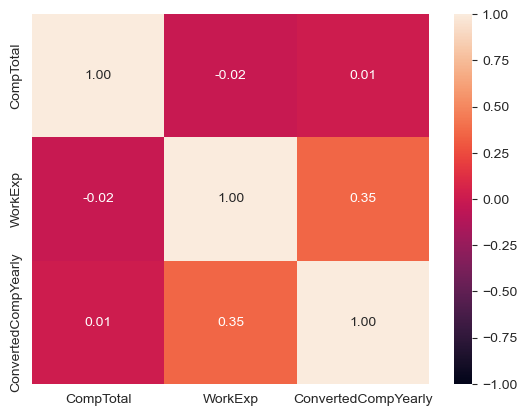

In [34]:
sns.heatmap(python.select_dtypes('float64', 'int').corr(), vmin=-1, vmax=1, annot=True, fmt='.2f') # numerical variables are not explicative of objective variable

AISearchWantToWorkWith


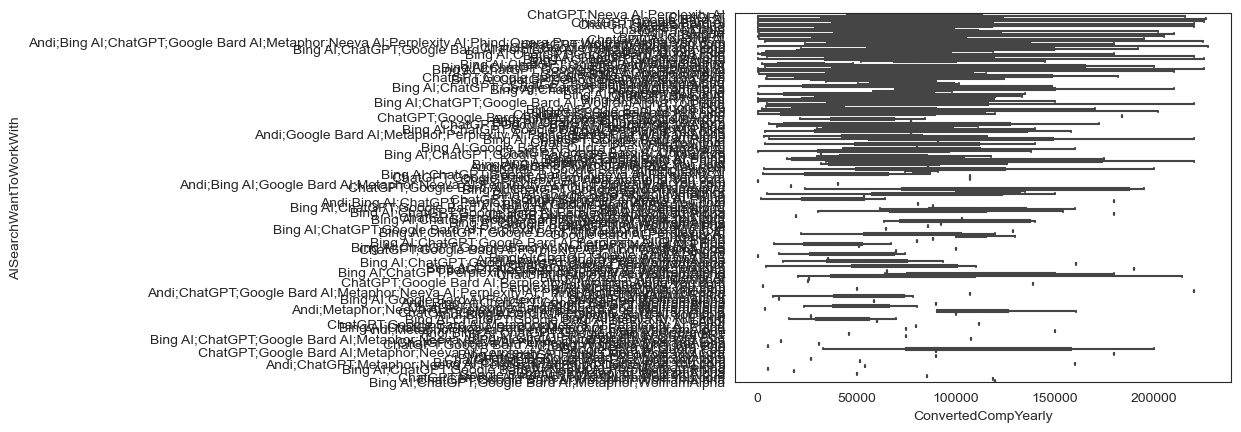

In [35]:
column = python.columns[40]
print(column)
sns.boxplot(data=python, x='ConvertedCompYearly', y=column, showfliers=False);

Imputing missing values

In [36]:
python_selected = pd.concat([python[categorical_variables], python[objective_variable]], axis=1).reset_index(drop=True)

In [37]:
python_selected.shape

(14256, 78)

In [38]:
python_selected.describe(include='all')

,MainBranch,Age,Employment,RemoteWork,CodingActivities,EdLevel,LearnCode,LearnCodeOnline,LearnCodeCoursesCert,YearsCode,YearsCodePro,DevType,OrgSize,PurchaseInfluence,TechList,BuyNewTool,Country,LanguageHaveWorkedWith,LanguageWantToWorkWith,DatabaseHaveWorkedWith,DatabaseWantToWorkWith,PlatformHaveWorkedWith,PlatformWantToWorkWith,WebframeHaveWorkedWith,WebframeWantToWorkWith,MiscTechHaveWorkedWith,MiscTechWantToWorkWith,ToolsTechHaveWorkedWith,ToolsTechWantToWorkWith,NEWCollabToolsHaveWorkedWith,NEWCollabToolsWantToWorkWith,OpSysPersonal use,OpSysProfessional use,OfficeStackAsyncHaveWorkedWith,OfficeStackAsyncWantToWorkWith,OfficeStackSyncHaveWorkedWith,OfficeStackSyncWantToWorkWith,AISearchHaveWorkedWith,AISearchWantToWorkWith,AIDevHaveWorkedWith,AIDevWantToWorkWith,NEWSOSites,SOVisitFreq,SOAccount,SOPartFreq,SOComm,AISelect,AISent,AIAcc,AIBen,AIToolInterested in Using,AIToolCurrently Using,AIToolNot interested in Using,AINextVery different,AINextNeither different nor similar,AINextSomewhat similar,AINextVery similar,AINextSomewhat different,TBranch,ICorPM,Knowledge_1,Knowledge_2,Knowledge_3,Knowledge_4,Knowledge_5,Knowledge_6,Knowledge_7,Knowledge_8,Frequency_1,Frequency_2,Frequency_3,TimeSearching,TimeAnswering,ProfessionalTech,Industry,SurveyLength,SurveyEase,ConvertedCompYearly
count,14256,14256,14251,14234,14230,14256,14233,11565,6024,14241,14202,14226,14246,14245,9300,13726,14256,14256,13416,12075,10172,11086,9013,10399,8782,9969,8281,13175,11754,14158,12786,14159,13507,12431,9678,14014,11834,9315,7709,4481,3512,14256,14222,14252,11011,14238,14256,10026,6634,10017,5871,6341,3797,2269,1013,1049,464,4181,13781,9813,9681,9572,9587,9572,9546,9544,9542,9524,9557,9567,9449,9682,9667,9504,8263,14110,14129,14256.000000
unique,2,8,13,3,94,8,527,3064,144,52,52,33,10,3,3,188,147,5775,6286,3056,2902,1878,1464,3726,3332,2754,3204,7677,6610,4837,3458,1077,898,2183,1300,2417,1534,125,148,58,92,16,5,3,6,6,3,6,56,5,477,286,300,173,88,92,65,187,2,2,5,5,5,5,5,5,5,5,5,5,5,5,5,240,12,3,3,NaN
top,I am a developer by profession,25-34 years old,"Employed, full-time","Hybrid (some remote, some in-person)",Hobby,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)","Other online resources (e.g., videos, blogs, f...",Formal documentation provided by the owner of ...,Udemy,10,5,"Developer, full-stack",20 to 99 employees,I have some influence,Investigate,Start a free trial;Ask developers I know/work ...,United States of America,Python,Python,PostgreSQL,PostgreSQL,Amazon Web Services (AWS),Amazon Web Services (AWS),Flask,FastAPI,NumPy;Pandas,.NET (5+),Pip,Docker,Visual Studio Code,Visual Studio Code,Windows,MacOS,Confluence;Jira,Markdown File,Microsoft Teams,Microsoft Teams,ChatGPT,ChatGPT,GitHub Copilot,GitHub Copilot,Stack Overflow;Stack Exchange,A few times per week,Yes,Less than once per month or monthly,"No, not really",Yes,Favorable,Increase productivity;Greater efficiency;Speed...,Somewhat trust,Learning about a codebase;Project planning;Wri...,Writing code,Collaborating with teammates,Writing code,Writing code,Writing code,Writing code,Writing code,Yes,Individual contributor,Agree,Agree,Agree,Agree,Agree,Agree,Agree,Agree,1-2 times a week,1-2 times a week,1-2 times a week,30-60 minutes a day,15-30 minutes a day,None of these,"Information Services, IT, Software Development...",Appropriate in length,Easy,NaN
freq,12414,7101,11812,6234,3232,6125,556,225,993,1303,1265,4115,3155,6182,8300,2297,3567,461,368,887,911,2080,1514,424,387,512,390,358,292,1416,1683,2162,2339,1043,722,1330,1022,5469,3701,3254,2468,9435,4694,11021,6114,5272,6678,4815,1233,3727,220,1155,393,282,285,371,169,1180,9838,8595,4473,3174,3814,4214,5047,3390,3620,3610,5879,4193,4971,3831,3070,1169,3819,11208,9228,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [39]:
python_selected.dropna(subset=categorical_variables, how='all', axis=0, inplace=True) #empty rows
python_selected.dropna(how='all', axis=1, inplace=True) #empty columns
print(python_selected.shape)

(14256, 78)


Fill the NaN's with the mode of the column because the selected variables are categorical.

In [40]:
for columna in python_selected[categorical_variables]:
    python_selected[columna].fillna(python_selected[columna].mode(), inplace=True)

In [41]:
python_dummy = create_dummy_df(python_selected, categorical_variables)

# Model

## Java

In [42]:
print(java_dummy.shape)

(6097, 35789)


We will use a linear regression over the data to model the yearly salary, so we must to normalize the data. The linear regression is an appropriate approach as a first model because their interpretability, we can get the degree of influence of each variable on the objective.

In [43]:
from sklearn.preprocessing import Normalizer

java_explanatory_variables = java_dummy.columns[java_dummy.columns != 'ConvertedCompYearly']
normalized = Normalizer().fit_transform(X=java_dummy[java_explanatory_variables], y=java_dummy['ConvertedCompYearly'])
java_normalized = pd.concat(
    [pd.DataFrame(normalized, columns=java_explanatory_variables), java_dummy['ConvertedCompYearly']],
    axis=1
)

In [44]:
java_X = java_normalized[java_explanatory_variables]
java_y = java_normalized['ConvertedCompYearly']
java_X_train, java_X_test, java_y_train, java_y_test = train_test_split(java_X, java_y, test_size=0.3, random_state=42)

Java R2 score en entrenamiento: 1.0
Java R2 score en prueba: 0.4831480384832654


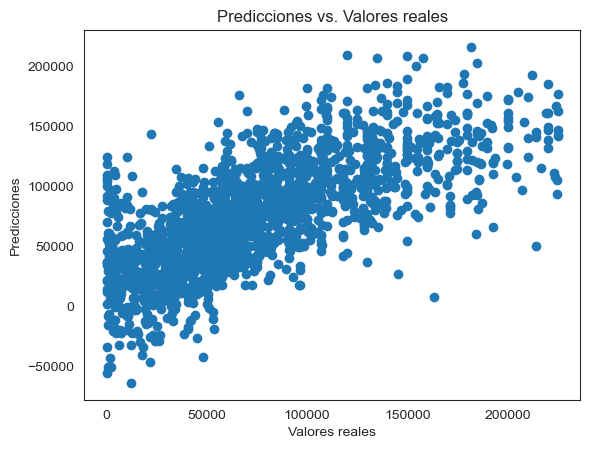

In [45]:
java_lm_model = LinearRegression().fit(java_X_train, java_y_train)

java_y_train_prediction = java_lm_model.predict(java_X_train)
java_y_test_prediction = java_lm_model.predict(java_X_test)

# evaluate the model
train_score = r2_score(java_y_train, java_y_train_prediction)
test_score = r2_score(java_y_test, java_y_test_prediction)
print('Java R2 score en entrenamiento:', train_score)
print('Java R2 score en prueba:', test_score)

# visualize predictions vs. real values
plt.scatter(java_y_test, java_y_test_prediction)
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs. Valores reales')
plt.show()

In [46]:
cutoffs = [4000, 3000, 2000, 1000, 500, 400, 300, 200, 100, 50, 40, 30, 20, 10, 9, 8, 7, 6, 5, 0]
cutoffs = [4000 - 10*i for i in range(396)]

def find_optimal_lm_mod(X, y, cutoffs, test_size=.30, random_state=42, plot=True):
    '''
    INPUT
    X - pandas dataframe, X matrix
    y - pandas dataframe, response variable
    cutoffs - list of ints, cutoff for number of non-zero values in dummy categorical vars
    test_size - float between 0 and 1, default 0.3, determines the proportion of data as test data
    random_state - int, default 42, controls random state for train_test_split
    plot - boolean, default 0.3, True to plot result

    OUTPUT
    r2_scores_test - list of floats of r2 scores on the test data
    r2_scores_train - list of floats of r2 scores on the train data
    lm_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model
    '''

    r2_scores_test, r2_scores_train, num_feats, results = [], [], [], dict()

    for cutoff in cutoffs:

        # reduce X matrix
        columns = X.iloc[:, np.where((X.sum() > cutoff) == True)[0]].columns
        reduce_X = pd.DataFrame(normalize(X[columns], axis=1), columns=columns)
        num_feats.append(len(columns))

        # split the data into train and test
        X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size=test_size, random_state=random_state)

        # fit the model and obtain pred response
        lm_model = LinearRegression().fit(X_train, y_train)
        y_train_prediction = lm_model.predict(X_train)
        y_test_prediction = lm_model.predict(X_test)

        # append the r2 value from the test set
        r2_scores_train.append(r2_score(y_train, y_train_prediction))
        r2_scores_test.append(r2_score(y_test, y_test_prediction))
        results[str(cutoff)] = r2_score(y_test, y_test_prediction)

    if plot:
        plt.plot(num_feats, r2_scores_train, label="Train", alpha=.5)
        plt.plot(num_feats, r2_scores_test, label="Test", alpha=.5)
        plt.xlabel('Number of Features')
        plt.ylabel('Rsquared')
        plt.title('Rsquared by Number of Features')
        plt.legend(loc='upper left')
        plt.show()

    best_cutoff = max(results, key=results.get)

    # reduce X matrix
    columns = X.iloc[:, np.where((X.sum() > int(best_cutoff)) == True)[0]].columns
    normalized = normalize(X[columns], axis=1)
    df_normalized = pd.concat([pd.DataFrame(normalized, columns=columns), y], axis=1)
    num_feats.append(reduce_X.shape[1])

    reduce_X = df_normalized[columns]
    y = df_normalized['ConvertedCompYearly']

    #split the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

    # fit the model
    lm_model = LinearRegression()
    lm_model.fit(X_train, y_train)

    return r2_scores_test, r2_scores_train, num_feats, lm_model, X_train, X_test, y_train, y_test

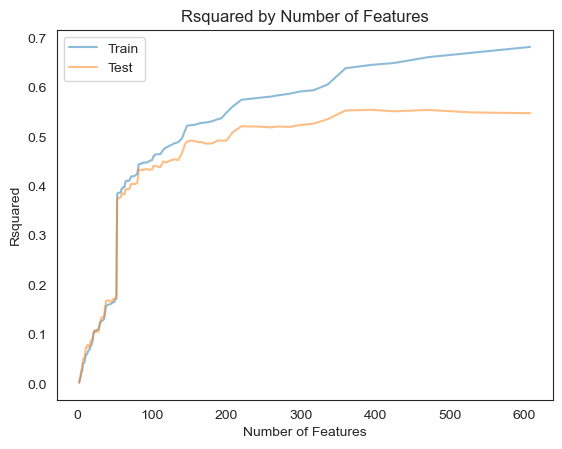

                 0
0.003008  0.002071
0.003008  0.002071
0.003008  0.002071
0.003008  0.002071
0.003008  0.002071
...            ...
0.645477  0.554697
0.649366  0.551613
0.661203  0.554431
0.670195  0.549309
0.681911  0.547823

[396 rows x 1 columns]


In [47]:
X = java_dummy[java_explanatory_variables]
y = java_dummy['ConvertedCompYearly']
r2_scores_test, r2_scores_train, num_feats, lm_model, X_train, X_test, y_train, y_test = find_optimal_lm_mod(X, y, cutoffs)

print(pd.DataFrame(r2_scores_test, r2_scores_train))

In [48]:
def coef_weights(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)

    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

coef_df = coef_weights(lm_model.coef_, X_train)
coef_df.head(20)

,est_int,coefs,abs_coefs
145,Country_United States of America,401499.126057,401499.126057
143,Country_Switzerland,370315.448267,370315.448267
131,Country_Australia,249155.386342,249155.386342
134,Country_Canada,187977.386758,187977.386758
144,Country_United Kingdom of Great Britain and No...,178682.165830,178682.165830
132,Country_Austria,139687.753814,139687.753814
139,Country_Netherlands,137483.276684,137483.276684
7,"Employment_Independent contractor, freelancer,...",132952.086984,132952.086984
136,Country_Germany,129600.740677,129600.740677
112,"OrgSize_Just me - I am a freelancer, sole prop...",-114941.523484,114941.523484


The country where the programmer works have the greatest importance in the salary explanation, other important feature is the kind of employment where to be freelancer is a good option.

In [49]:
df = pd.DataFrame({'num_feats': num_feats[:-1], 'train': r2_scores_train, 'test': r2_scores_test})
df.set_index('num_feats').diff().sort_values(by=['num_feats', 'test'], ascending=False)
df.sort_values(by='test', ascending=False)

print(X_train.shape[1])
print(r2_scores_test[np.argmax(r2_scores_test)]) # the model we should implement test_r2
print(r2_scores_train[np.argmax(r2_scores_test)]) # the model we should implement train_r2

394
0.5546966110097945
0.6454771264237238


## Python

In [50]:
print(python_dummy.shape)

(14256, 73167)


In [51]:
from sklearn.preprocessing import Normalizer

python_explanatory_variables = python_dummy.columns[python_dummy.columns != 'ConvertedCompYearly']
normalized = Normalizer().fit_transform(X=python_dummy[python_explanatory_variables], y=python_dummy['ConvertedCompYearly'])
#python_normalized = pd.concat(
#    [pd.DataFrame(normalized, columns=python_explanatory_variables), python_dummy['ConvertedCompYearly']],
#    axis=1
#)

In [52]:
python_X = pd.DataFrame(normalized, columns=python_explanatory_variables, dtype='float32') #python_normalized[python_explanatory_variables]
python_y = python_dummy['ConvertedCompYearly']
python_X_train, python_X_test, python_y_train, python_y_test = train_test_split(python_X, python_y, test_size=0.3, random_state=42)

python R2 score en entrenamiento: 0.9999999988191505
python R2 score en prueba: 0.47465679767405133


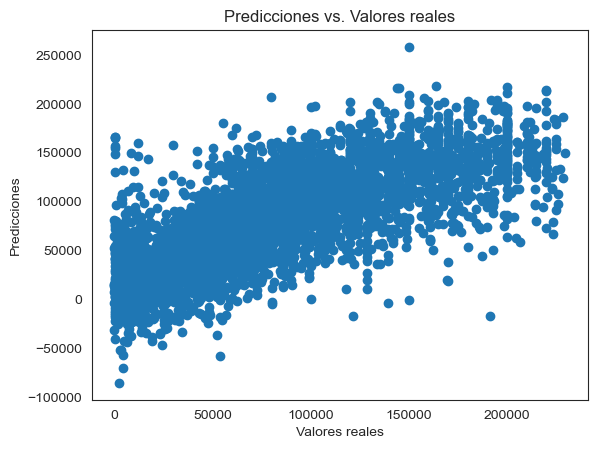

In [53]:
python_lm_model = LinearRegression().fit(python_X_train, python_y_train)

python_y_train_prediction = python_lm_model.predict(python_X_train)
python_y_test_prediction = python_lm_model.predict(python_X_test)

# evaluate the model
train_score = r2_score(python_y_train, python_y_train_prediction)
test_score = r2_score(python_y_test, python_y_test_prediction)
print('python R2 score en entrenamiento:', train_score)
print('python R2 score en prueba:', test_score)

# visualize predictions vs. real values
plt.scatter(python_y_test, python_y_test_prediction)
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs. Valores reales')
plt.show()

In [54]:
cutoffs = [4000, 3000, 2000, 1000, 500, 400, 300, 200, 100, 50, 40, 30, 20, 10, 9, 8, 7, 6, 5, 0]
cutoffs = [4000 - 10*i for i in range(396)]

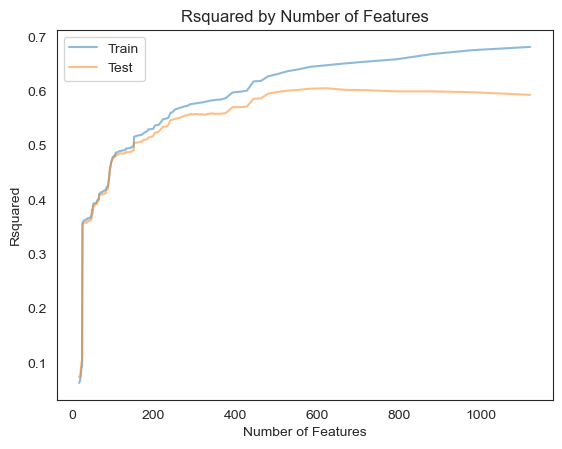

                 0
0.062922  0.073602
0.062922  0.073602
0.062922  0.073602
0.062922  0.073602
0.062922  0.073602
...            ...
0.654850  0.602147
0.659124  0.599969
0.668713  0.600037
0.675895  0.598347
0.681860  0.593568

[396 rows x 1 columns]


In [55]:
X = python_dummy[python_explanatory_variables]
y = python_dummy['ConvertedCompYearly']
r2_scores_test, r2_scores_train, num_feats, lm_model, X_train, X_test, y_train, y_test = find_optimal_lm_mod(X, y, cutoffs)

print(pd.DataFrame(r2_scores_test, r2_scores_train))

In [56]:
coef_df = coef_weights(lm_model.coef_, X_train)
coef_df.head(20)

,est_int,coefs,abs_coefs
217,Country_United States of America,441922.536524,441922.536524
215,Country_Switzerland,373706.662025,373706.662025
204,Country_Israel,321647.171962,321647.171962
199,Country_Denmark,252000.335896,252000.335896
197,Country_Canada,248878.070786,248878.070786
193,Country_Australia,229346.966791,229346.966791
216,Country_United Kingdom of Great Britain and No...,182156.917764,182156.917764
208,Country_Norway,173294.016512,173294.016512
207,Country_New Zealand,164459.145780,164459.145780
202,Country_Germany,159213.248993,159213.248993


In case of Python programmers the most determinant factor is the country of work.

In [57]:
df = pd.DataFrame({'num_feats': num_feats[:-1], 'train': r2_scores_train, 'test': r2_scores_test})
df.set_index('num_feats').diff().sort_values(by=['num_feats', 'test'], ascending=False)
df.sort_values(by='test', ascending=False)

print(X_train.shape[1])
print(r2_scores_test[np.argmax(r2_scores_test)]) # the model we should implement test_r2
print(r2_scores_train[np.argmax(r2_scores_test)]) # the model we should implement train_r2

624
0.6056870047326441
0.6483288196407546
